In [24]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from src.metrics import adaptive_calibration_error, brier_score
from src.estimates import get_confidence_estimates
from src.utils import evaluate_reductions, get_factor_results

In [25]:
graphics_path = "../images/pdf/"
tables_path = "../tables/"
list_of_all_models = [
    "bert-base-cased", "bert-large-cased", "gemma-2b", "gemma-7b",
    "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "opt-125m",
    "opt-350m", "opt-1.3b", "opt-6.7b", "roberta-base", "roberta-large",
    "xlm-roberta-base", "xlm-roberta-large"
]
instance_lvl_results = pd.read_json(
    "../../scores/BEAR/instance_level_results.json",
    orient="records",
    lines=True
)

# B Reduction Strategy Evaluation

In [26]:
# Evaluate over all models
if os.path.isfile("../../scores/BEAR/reduction_strategies.json"):
    reduction_results = pd.read_json(
        "../../scores/BEAR/reduction_strategies.json",
        orient="records",
        lines=True)
else:
    reduction_results = evaluate_reductions(models=list_of_all_models)
    reduction_results.to_json("../../scores/BEAR/reduction_strategies.json", orient="records", lines=True)

In [27]:
# Adding the harmonic mean to the results: 2*ACC*(1-ACE)/(ACC+(1-ACE))
acc = reduction_results["accuracy"]
ace = reduction_results["ace"]
reduction_results["harmonic_mean"] = (2*acc*(1-ace))/(acc+(1-ace))

reduction_labels = {
    "pll_scores_sum": "Sum",
    "pll_scores_avg": "Mean",
    "pll_scores_answer_sum": "Sum (A)",
    "pll_scores_answer_avg": "Mean (A)",
}
reduction_results["reduction"] = reduction_results["reduction"].map(reduction_labels)

## Figure: Bar Plot Reduction Strategies

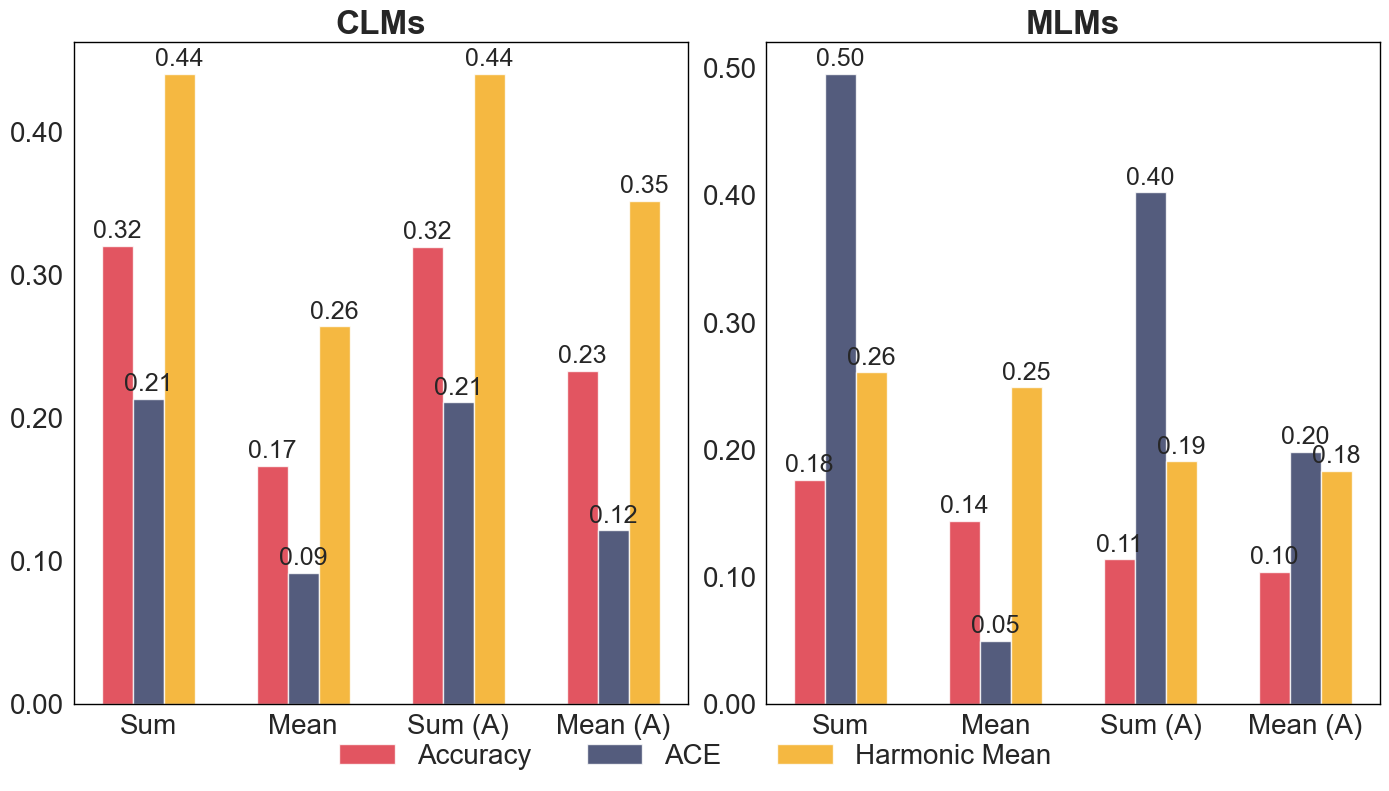

In [28]:
mean_per_metric = (
    reduction_results.groupby(["reduction", "model_type"])[["accuracy", "ace", "harmonic_mean"]]
    .mean()
    .reset_index()
)

metric_labels = {"accuracy": "Accuracy", "ace": "ACE", "harmonic_mean": "Harmonic Mean"}
df = mean_per_metric.melt(
    id_vars=["reduction", "model_type"],
    value_vars=metric_labels.keys(),
    var_name="metric",
    value_name="value"
)
df["metric"] = df["metric"].map(metric_labels)

colors = {"Accuracy": "#db2b39", "ACE": "#29335c", "Harmonic Mean": "#f3a712"}
reductions = ["Sum", "Mean", "Sum (A)", "Mean (A)"]
metrics = list(colors.keys())
model_types = df["model_type"].unique()

fig, axs = plt.subplots(1, 2, figsize=(14, 8), sharey=False)

x = np.arange(len(reductions))
bar_width = 0.2

for ax, model_type in zip(axs, model_types):
    data = df[df["model_type"] == model_type]
    for i, metric in enumerate(metrics):
        values = (
            data[data["metric"] == metric]
            .set_index("reduction")
            .reindex(reductions)["value"]
            .values
        )
        ax.bar(x + i * bar_width, values, width=bar_width, label=metric, color=colors[metric], alpha=0.8)
        for xi, v in zip(x, values):
            ax.text(xi + i * bar_width, v + 0.002, f"{v:.2f}", ha="center", va="bottom", fontsize=18)

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(reductions, fontsize=20)
    ax.set_title("CLMs" if model_type == "CLM" else "MLMs", fontsize=24, fontweight="bold")
    ax.set_facecolor("white")
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.tick_params(axis="y", which="major", labelsize=20)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color("black")

fig.legend(metrics, loc="lower center", ncol=3, fontsize=20, frameon=False, bbox_to_anchor=(0.5, 0))
fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(graphics_path + "reductions_barplot.pdf", bbox_inches="tight", format="pdf")
plt.show()

## Figure: Confidence Distribution opt-1.3b

In [29]:
reductions = ["sum", "mean"]
data_rows = []

for reduction in reductions:
    for only_answers in [False, True]:
        result = get_confidence_estimates(
            path="../../scores/BEAR",
            model="opt-1.3b",
            reduction=reduction,
            only_answers=only_answers
        )
        row = {
            "reduction": reduction,
            "only_answers": only_answers,
            "predictions": result["correctly_predicted"],
            "confidence": result["base_conf"]
        }
        data_rows.append(row)

results_df = pd.DataFrame(data_rows)

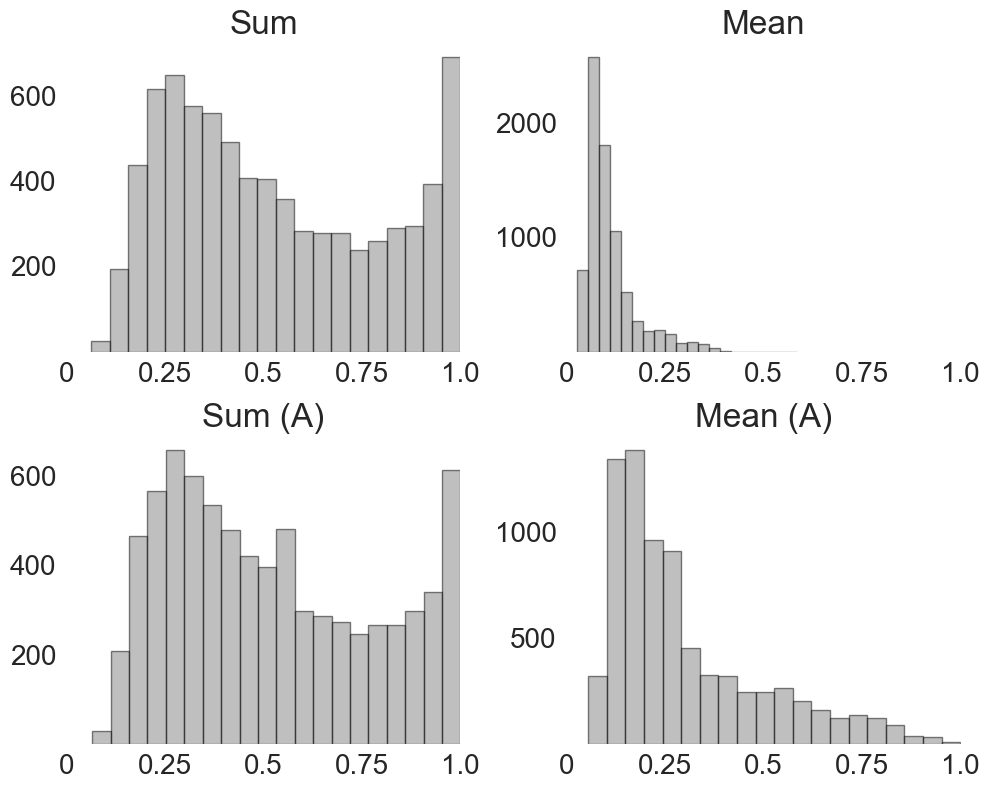

In [30]:
confidences = [
    results_df.query("reduction == 'sum' and only_answers == False")["confidence"].iloc[0],
    results_df.query("reduction == 'mean' and only_answers == False")["confidence"].iloc[0],
    results_df.query("reduction == 'sum' and only_answers == True")["confidence"].iloc[0],
    results_df.query("reduction == 'mean' and only_answers == True")["confidence"].iloc[0],
]

titles = ["Sum", "Mean", "Sum (A)", "Mean (A)"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=False)
axes = axes.flatten()

for col_idx, (data, reduction) in enumerate(zip(confidences, titles)):
    ax = axes[col_idx]
    ax.hist(data, bins=20, color="gray", edgecolor="black", alpha=0.5)
    ax.set_facecolor("white")
    ax.set_title(f"{reduction}", fontsize=24)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(0, 1)
    ax.set_ylim(0.01, None)
    
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1.0])
    ax.tick_params(axis="both", which="major", labelsize=20)
plt.tight_layout()
plt.savefig(graphics_path + "confidence_distribution_opt1_3b.pdf", format="pdf")
plt.show()

# C Aggregation Strategies

## Table: Brier Scores for the different aggregation strategies

In [31]:
bs_results = {
    "model": [],
    "min": [],
    "max": [],
    "voting_2": [],
    "voting_3": [],
    "voting_4": [],
    "voting_5": []
}
for model in list_of_all_models:
    r = instance_lvl_results.query("model == @model")
    bs_results["model"].append(model)
    bs_results["min"].append(brier_score(r.min_conf_correct, r.average_conf_min_conf))
    bs_results["max"].append(brier_score(r.max_conf_correct, r.average_conf_max_conf))
    bs_results["voting_2"].append(brier_score(r.voting_2_correct, r.average_conf_voting_2))
    bs_results["voting_3"].append(brier_score(r.voting_3_correct, r.average_conf_voting_3))
    bs_results["voting_4"].append(brier_score(r.voting_4_correct, r.average_conf_voting_4))
    bs_results["voting_5"].append(brier_score(r.voting_5_correct, r.average_conf_voting_5))    

In [32]:
bs_df = pd.DataFrame(bs_results).round(3)
formatters = {
    col: (
        (lambda x: r"\texttt{" + str(x) + "}") if col == "model"
        else (lambda x: r"\BrierCell{" + f"{x:.3f}" + "}")
    )
    for col in bs_df.columns
}
(
    pd.DataFrame(bs_results)
    .to_latex(
        tables_path + "brier_scores_aggregations.txt",
        index=False,
        float_format="%.3f",
        formatters=formatters,
        escape=False
    )
)

## Figure: Accuracy Rejection Curves due to (early) vote failures

In [33]:
votes = ["2", "3", "4", "5"]
results = []

for model in list_of_all_models:
    lm = instance_lvl_results.query("model == @model")
    for vote in votes:
        frac_rejected = lm[f"voting_{vote}_fail"].mean()
        frac_true = lm[lm[f"voting_{vote}_fail"] == False][f"voting_{vote}_correct"].mean()
                
        results.append({
            "model": model,
            "votes": vote,
            "rejected_frac": frac_rejected,
            "retained_frac": 1-frac_rejected,
            "frac_true": frac_true
        })

voting_rejections = pd.DataFrame(results)

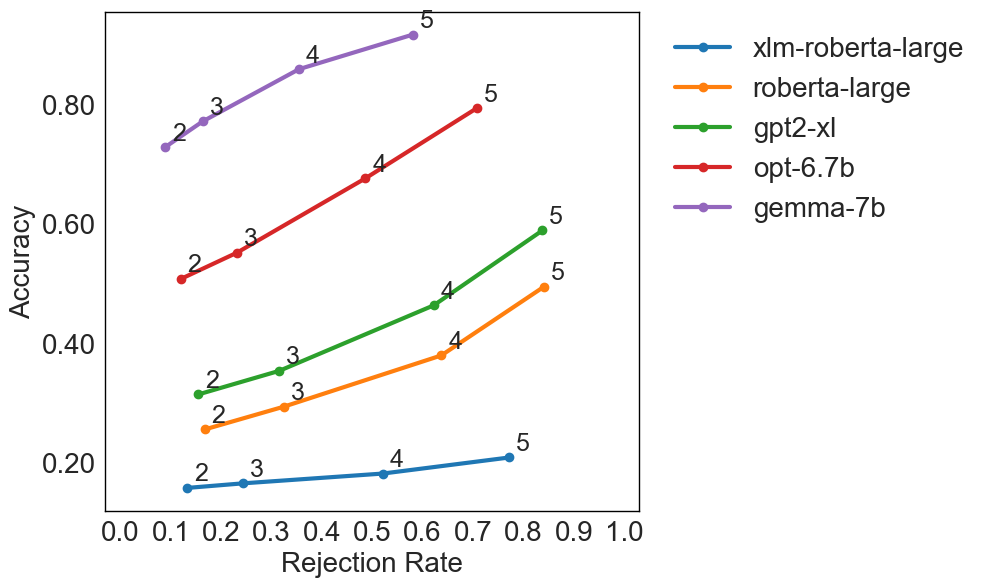

In [34]:
models = ["xlm-roberta-large", "roberta-large", "gpt2-xl", "opt-6.7b", "gemma-7b"]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for model in models:
    m = voting_rejections.query("model == @model")
    
    ax.plot(m.rejected_frac, m.frac_true, marker="o", label=model, linewidth=3, markersize=6)
    
    for idx, label in zip([0, 1, 2, 3, 4], ["2", "3", "4", "5"]):
        if idx < len(m):
            x = m.rejected_frac.iloc[idx]
            y = m.frac_true.iloc[idx]
            ax.annotate(label, (x, y), textcoords="offset points", xytext=(5,5), fontsize=18)

ax.legend(frameon=False, fontsize=20, loc="upper left", bbox_to_anchor=(1.02, 1)) 
ax.set_xlim(-0.03, 1.03)
ax.set_xticks([j/10 for j in range(11)])
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}"))
ax.set_xlabel("Rejection Rate", fontsize=20)
ax.set_ylabel("Accuracy", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.0)
    spine.set_color("black")

plt.tight_layout()
plt.savefig(graphics_path + "accuracy_rejection_curves_votings.pdf", format="pdf")
plt.show()

# D Overview of selected domain per model pair

## Compute difference in accuracy for matched CLM-MLM pairs

In [35]:
d = {
    "model": [],
    "domain": [],
    "number_of_instances": [],
    "accuracy": [],
}
models = [
    "opt-125m", "roberta-base", "gpt2-medium", "bert-base-cased", "gpt2-large",
    "roberta-large", "opt-350m", "bert-large-cased", "gpt2", "xlm-roberta-large"]
for model in models:
    data = instance_lvl_results.query("model == @model")
    data = data.explode("domains")
    for domain in data.domains.unique().tolist():
        per_domain_data = data.query("domains == @domain")
        d["model"].append(model)
        d["domain"].append(domain)
        d["number_of_instances"].append(len(per_domain_data))
        accuracy = per_domain_data["bear_score"].mean()
        d["accuracy"].append(accuracy)

In [36]:
# Now compute difference in accuracy for each pair
temp_df = pd.DataFrame(d)

pairs = [
    ("opt-125m", "roberta-base"),
    ("gpt2-medium", "bert-base-cased"),
    ("gpt2-large", "roberta-large"),
    ("opt-350m", "bert-large-cased"),
    ("gpt2", "xlm-roberta-large"),
]

results = []

for m1, m2 in pairs:
    tmp = (
        temp_df.query("model == @m1")[["domain", "accuracy"]]
        .merge(
            temp_df.query("model == @m2")[["domain", "accuracy"]],
            on="domain",
            suffixes=(f"_{m1}", f"_{m2}")
        )
    )
    tmp = (
        tmp.assign(accuracy_diff=lambda x: (x[f"accuracy_{m1}"] - x[f"accuracy_{m2}"]).abs())
        .sort_values("accuracy_diff")
        .head(1)
    )
    results.append({
        "pair": f"{m1} vs {m2}",
        "domain": tmp["domain"].iloc[0],
        f"accuracy_{m1}": tmp[f"accuracy_{m1}"].iloc[0],
        f"accuracy_{m2}": tmp[f"accuracy_{m2}"].iloc[0],
    })
pd.DataFrame(results)

,pair,domain,accuracy_opt-125m,accuracy_roberta-base,accuracy_gpt2-medium,accuracy_bert-base-cased,accuracy_gpt2-large,accuracy_roberta-large,accuracy_opt-350m,accuracy_bert-large-cased,accuracy_gpt2,accuracy_xlm-roberta-large
0,opt-125m vs roberta-base,Arts,0.105853,0.103635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,gpt2-medium vs bert-base-cased,Economic,NaN,NaN,0.15964,0.148288,NaN,NaN,NaN,NaN,NaN,NaN
2,gpt2-large vs roberta-large,Biographical,NaN,NaN,NaN,NaN,0.196347,0.189533,NaN,NaN,NaN,NaN
3,opt-350m vs bert-large-cased,Movies,NaN,NaN,NaN,NaN,NaN,NaN,0.104889,0.100593,NaN,NaN
4,gpt2 vs xlm-roberta-large,Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.099445,0.100893


In [37]:
# Wiki-FACTOR Benchmark

In [38]:
list_of_all_models = [
    "gemma-2b.jsonl", "gemma-7b.jsonl",
    "gpt2.jsonl", "gpt2-medium.jsonl", "gpt2-large.jsonl", "gpt2-xl.jsonl",
    "opt-125m.jsonl", "opt-350m.jsonl", "opt-1.3b.jsonl", "opt-6.7b.jsonl"
]
factor = get_factor_results(list_of_all_models)

../../scores/FACTOR/sum/gemma-2b.jsonl
../../scores/FACTOR/sum/gemma-7b.jsonl
../../scores/FACTOR/sum/gpt2.jsonl
../../scores/FACTOR/sum/gpt2-medium.jsonl
../../scores/FACTOR/sum/gpt2-large.jsonl
../../scores/FACTOR/sum/gpt2-xl.jsonl
../../scores/FACTOR/sum/opt-125m.jsonl
../../scores/FACTOR/sum/opt-350m.jsonl
../../scores/FACTOR/sum/opt-1.3b.jsonl
../../scores/FACTOR/sum/opt-6.7b.jsonl


In [39]:
ace_results = {
    "model": [],
    "accuracy": [],
    "ace_base": [],
    "ace_margin": []
}

bs_results = {
    "model": [],
    "bs_base": [],
    "bs_margin": []
}

for model in list_of_all_models:
    model = model.removesuffix(".jsonl")
    d = factor.query("model == @model")
    accuracy = d["correctly_predicted"].mean()
    ace_base = adaptive_calibration_error(d["correctly_predicted"], d["base_conf"])
    ace_margin = adaptive_calibration_error(d["correctly_predicted"], d["margin_conf"])
    bs_base = brier_score(d["correctly_predicted"], d["base_conf"])
    bs_margin = brier_score(d["correctly_predicted"], d["margin_conf"])
    
    ace_results["model"].append(model)
    ace_results["accuracy"].append(round(accuracy*100, 2))  
    ace_results["ace_base"].append(round(ace_base, 3))
    ace_results["ace_margin"].append(round(ace_margin, 3))
    bs_results["model"].append(model)
    bs_results["bs_base"].append(round(bs_base, 3))
    bs_results["bs_margin"].append(round(bs_margin, 3))

ace_df = pd.DataFrame(ace_results)
bs_df = pd.DataFrame(bs_results)

In [40]:
(
    ace_df
    .round(3)
    .to_latex(
        "../tables/metrics_factor.txt",
        index=False,
        float_format="%.3f",
        formatters={
            "model": lambda x: r"\texttt{" + str(x) + "}"
        },
        escape=False,
    )
)

(
    bs_df
    .round(3)
    .to_latex(
        "../tables/brier_scores_factor.txt",
        index=False,
        float_format="%.3f",
        formatters={
            "model": lambda x: r"\texttt{" + str(x) + "}"
        },
        escape=False,
    )
)

## Figure: Accuracy against ACE for FACTOR & BEAR

In [41]:
bear = pd.read_json("../../scores/BEAR/bear_sampled_data.json", orient="records", lines=True).query("sample_size == 5")
bear["accuracy"] = round(bear["accuracy"]*100, 2)
# Remove the data for the MLMs
bear_data = bear[~bear["model"].isin([
    "bert-base-cased", "bert-large-cased",
    "roberta-base", "roberta-large",
    "xlm-roberta-base", "xlm-roberta-large"
])]

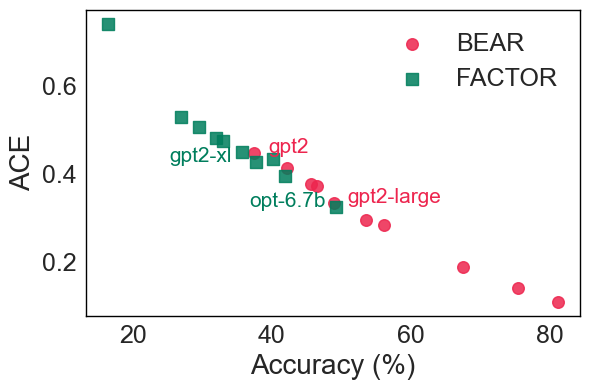

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))

# BEAR
ax.scatter(
    bear_data["accuracy"],
    bear_data["ace"],
    label="BEAR",
    marker="o",
    s=70,
    alpha=0.85,
    color="#ed254e"
)

# FACTOR
ax.scatter(
    ace_df["accuracy"],
    ace_df["ace_base"],
    label="FACTOR",
    marker="s",
    s=70,
    alpha=0.85,
    color="#007e5d"
)

for _, row in bear_data.iterrows():
    if row["model"] in ["gpt2", "gpt2-large"]:
        ax.text(
            row["accuracy"]+2,
            row["ace"],
            row["model"],
            fontsize=15,
            color="#ed254e"
        )

for _, row in ace_df.iterrows():
    if row["model"] in ["gpt2-xl", "opt-6.7b"]:
        ax.text(
            row["accuracy"]-12.5,
            row["ace_base"],
            row["model"],
            fontsize=15,
            color="#007e5d"
        )

ax.set_xlabel("Accuracy (%)", fontsize=20)
ax.set_ylabel("ACE", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=18)
ax.grid(False)
ax.set_facecolor("white")
for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_color("black")
ax.legend(frameon=False, fontsize=18)

plt.tight_layout()
plt.savefig("../images/pdf/ace_vs_accuracy_factor_bear.pdf", format="pdf")
plt.show()